In [1]:
import sys
sys.path.append('../')

from generate_bf import *
from computesk import *
import numpy as np
import torch

import numpy as np
import copy
import torch
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt

This is for a simple UMNN parameterization [16, 32, 8]. That was conducted in our experiments to see whether a small model can learn the true map Sk well.

In [2]:
num_test = 10000
num_pairs = 5
num_features = num_pairs * 2
hidden_layers = [16, 32, 8]
nb_steps = 50

lr = 0.01
num_epochs = 100

In [3]:
testing_samples_path = 'BF/BF-samples/bf-testing_samples5p.txt'
validation_samples_path = 'BF/BF-samples/bf-validation_samples5p.txt'
save_path = 'BF/BF-saved_models/BF-5p-16_32_8.es' # Change this!

In [4]:
# testing_samples = generate_easy_ng(num_test, num_pairs)
# validation_samples = generate_easy_ng(num_test, num_pairs)

# np.savetxt(testing_samples_path, testing_samples)
# np.savetxt(validation_samples_path, validation_samples)

In [5]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)

print(test_samples)

tensor([[ 0.8289,  1.3503,  0.3256,  ...,  0.1962, -0.2516, -0.4202],
        [-0.0587,  0.0026, -0.6916,  ..., -0.1389,  0.4334, -0.5928],
        [ 0.5460,  0.4231, -0.8863,  ...,  0.5025,  0.9002, -0.2475],
        ...,
        [ 0.3147,  0.5331,  1.0124,  ...,  0.5237,  0.6708,  0.3994],
        [-0.4309,  1.3082, -1.1901,  ...,  0.2698, -0.3909,  0.1544],
        [ 1.2388,  0.5343, -0.1850,  ...,  2.4728, -0.6737,  1.1008]])


In [6]:
training_sizes = [5000]
random_regs = [1, 0.1, 0.01, 0.001, 0]

In [7]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [8]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

In [9]:
num_train = training_sizes[0]
X_tr = generate_easy_bf(num_train, num_pairs)

for i in kths:
    kth = i
    print('kth =', kth)
    best_val_overall = float('inf')
    opt_reg = 0
    opt_Sk = None # should this be moved in?
    each_learnt_map = {}
    non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

    for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
        regLambda = random_regs[j]
        Sk = copy.deepcopy(fixed_map)[kth]
        optimizer = optim.Adam(Sk.parameters(), lr=lr)
        n = X_tr.shape[0]
        early_stop_counter = 0
        best_epoch = 0
        best_valL = float('inf')
        for epoch in range(num_epochs):
            zk = X_tr.detach().requires_grad_(True)
            h = zk[:, non_kth]
            x = zk[:, [kth]]

            sk_zi = Sk(x, h)
            jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
            loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n #mapS_losses(sk_zi, jacobian).sum(axis=0) / n#, kth)
            regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
            loss += regLambda * regulariser
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation
            Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
            val_loss = test_losses(Sk_zi_val, jacobian_val)#, kth)
            print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

            # Save the smallest validation loss at each loop.
            if val_loss[1] < best_valL:
                best_valL = val_loss[1]
                if val_loss[1] < best_val_overall: # overall for all λ and epoch
                    best_val_overall = val_loss[1]
                    opt_reg = regLambda
                    opt_Sk = Sk
                    
                best_epoch = epoch
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            # Check for early stopping
            if early_stop_counter >= 10:
                print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                break

        each_learnt_map.setdefault(regLambda, []).append(Sk)

    # Test the best model
    Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

    all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
    print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

    all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
    all_opt_maps.setdefault(num_train, []).append(opt_Sk)
    opt_regs.setdefault(num_train, []).append(opt_reg)
    
print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.2688608765602112, 1.5929067134857178)
Val 5000st λ = 1, Epoch 1: (0.2334120124578476, 1.6379988193511963)
Val 5000st λ = 1, Epoch 2: (0.2325192391872406, 1.6336345672607422)
Val 5000st λ = 1, Epoch 3: (0.24365952610969543, 1.6124365329742432)
Val 5000st λ = 1, Epoch 4: (0.26001110672950745, 1.5887800455093384)
Val 5000st λ = 1, Epoch 5: (0.2757585942745209, 1.5694833993911743)
Val 5000st λ = 1, Epoch 6: (0.2845514416694641, 1.5598334074020386)
Val 5000st λ = 1, Epoch 7: (0.2873653173446655, 1.5581148862838745)
Val 5000st λ = 1, Epoch 8: (0.2874055504798889, 1.560477375984192)
Val 5000st λ = 1, Epoch 9: (0.28664639592170715, 1.5624947547912598)
Val 5000st λ = 1, Epoch 10: (0.28539279103279114, 1.5626202821731567)
Val 5000st λ = 1, Epoch 11: (0.2840755581855774, 1.5619229078292847)
Val 5000st λ = 1, Epoch 12: (0.2834503948688507, 1.5609782934188843)
Val 5000st λ = 1, Epoch 13: (0.28420835733413696, 1.5597929954528809)
Val 5000st λ = 1, Epoch 14: (0.286656826

Random Regs:  20%|██        | 1/5 [00:31<02:06, 31.57s/it]

Val 5000st λ = 1, Epoch 31: (0.2986687123775482, 1.5379576683044434)
Early stopping at Epoch 31 for best epoch 21.
Val 5000st λ = 0.1, Epoch 0: (0.4916640520095825, 1.45713472366333)
Val 5000st λ = 0.1, Epoch 1: (0.6548231244087219, 1.4299287796020508)
Val 5000st λ = 0.1, Epoch 2: (0.7584515810012817, 1.4245936870574951)
Val 5000st λ = 0.1, Epoch 3: (0.7449176907539368, 1.4171669483184814)
Val 5000st λ = 0.1, Epoch 4: (0.6807738542556763, 1.4096064567565918)
Val 5000st λ = 0.1, Epoch 5: (0.6146243810653687, 1.4085125923156738)
Val 5000st λ = 0.1, Epoch 6: (0.5737806558609009, 1.4094133377075195)
Val 5000st λ = 0.1, Epoch 7: (0.5635114312171936, 1.4050461053848267)
Val 5000st λ = 0.1, Epoch 8: (0.5752400159835815, 1.3962037563323975)
Val 5000st λ = 0.1, Epoch 9: (0.599525511264801, 1.386081576347351)
Val 5000st λ = 0.1, Epoch 10: (0.6274071931838989, 1.3766154050827026)
Val 5000st λ = 0.1, Epoch 11: (0.6506817936897278, 1.367860198020935)
Val 5000st λ = 0.1, Epoch 12: (0.663727700710296

Random Regs:  40%|████      | 2/5 [02:02<03:20, 66.73s/it]

Val 5000st λ = 0.1, Epoch 99: (1.155558466911316, 1.2137964963912964)
Val 5000st λ = 0.01, Epoch 0: (0.4937571585178375, 1.4573652744293213)
Val 5000st λ = 0.01, Epoch 1: (0.6670658588409424, 1.4310603141784668)
Val 5000st λ = 0.01, Epoch 2: (0.8293814659118652, 1.4330322742462158)
Val 5000st λ = 0.01, Epoch 3: (0.8572268486022949, 1.4313328266143799)
Val 5000st λ = 0.01, Epoch 4: (0.8007172346115112, 1.4196983575820923)
Val 5000st λ = 0.01, Epoch 5: (0.7212750315666199, 1.4092103242874146)
Val 5000st λ = 0.01, Epoch 6: (0.6517643928527832, 1.4053752422332764)
Val 5000st λ = 0.01, Epoch 7: (0.6088113188743591, 1.4050639867782593)
Val 5000st λ = 0.01, Epoch 8: (0.5971192121505737, 1.4019075632095337)
Val 5000st λ = 0.01, Epoch 9: (0.6091581583023071, 1.3948955535888672)
Val 5000st λ = 0.01, Epoch 10: (0.6362699866294861, 1.3864835500717163)
Val 5000st λ = 0.01, Epoch 11: (0.6703779101371765, 1.3788714408874512)
Val 5000st λ = 0.01, Epoch 12: (0.7029671669006348, 1.3721351623535156)
Val 

Random Regs:  60%|██████    | 3/5 [03:41<02:42, 81.17s/it]

Val 5000st λ = 0.01, Epoch 99: (1.9344757795333862, 1.2462366819381714)
Val 5000st λ = 0.001, Epoch 0: (0.49379485845565796, 1.4573663473129272)
Val 5000st λ = 0.001, Epoch 1: (0.6679663062095642, 1.4311388731002808)
Val 5000st λ = 0.001, Epoch 2: (0.8353737592697144, 1.4338387250900269)
Val 5000st λ = 0.001, Epoch 3: (0.8677964806556702, 1.4329503774642944)
Val 5000st λ = 0.001, Epoch 4: (0.812268078327179, 1.4211721420288086)
Val 5000st λ = 0.001, Epoch 5: (0.731962263584137, 1.4099441766738892)
Val 5000st λ = 0.001, Epoch 6: (0.660605251789093, 1.4053306579589844)
Val 5000st λ = 0.001, Epoch 7: (0.6153151988983154, 1.404754877090454)
Val 5000st λ = 0.001, Epoch 8: (0.6013821959495544, 1.401883840560913)
Val 5000st λ = 0.001, Epoch 9: (0.6117889881134033, 1.3952327966690063)
Val 5000st λ = 0.001, Epoch 10: (0.6380773186683655, 1.3870028257369995)
Val 5000st λ = 0.001, Epoch 11: (0.6720332503318787, 1.3794461488723755)
Val 5000st λ = 0.001, Epoch 12: (0.7053202986717224, 1.37279117107

Random Regs:  80%|████████  | 4/5 [05:08<01:23, 83.73s/it]

Val 5000st λ = 0.001, Epoch 95: (2.150022506713867, 1.2783175706863403)
Early stopping at Epoch 95 for best epoch 85.
Val 5000st λ = 0, Epoch 0: (0.49379488825798035, 1.4573663473129272)
Val 5000st λ = 0, Epoch 1: (0.6680251955986023, 1.4311432838439941)
Val 5000st λ = 0, Epoch 2: (0.836075484752655, 1.433934211730957)
Val 5000st λ = 0, Epoch 3: (0.8690857291221619, 1.4331544637680054)
Val 5000st λ = 0, Epoch 4: (0.8136928081512451, 1.421366572380066)
Val 5000st λ = 0, Epoch 5: (0.7332869172096252, 1.4100444316864014)
Val 5000st λ = 0, Epoch 6: (0.661698043346405, 1.4053181409835815)
Val 5000st λ = 0, Epoch 7: (0.6160680651664734, 1.4047027826309204)
Val 5000st λ = 0, Epoch 8: (0.601673424243927, 1.4018977880477905)
Val 5000st λ = 0, Epoch 9: (0.6117907166481018, 1.395294189453125)
Val 5000st λ = 0, Epoch 10: (0.6379315257072449, 1.3870792388916016)
Val 5000st λ = 0, Epoch 11: (0.6718106865882874, 1.3795068264007568)
Val 5000st λ = 0, Epoch 12: (0.7052140831947327, 1.3728580474853516)


Val 5000st λ = 0, Epoch 99: (2.3730759620666504, 1.3021996021270752)


Test 5000, λ = 0.1: [(1.1284441947937012, 1.2001454830169678)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.5295845866203308, 1.5984364748001099)
Val 5000st λ = 1, Epoch 1: (0.4650011658668518, 1.6307138204574585)
Val 5000st λ = 1, Epoch 2: (0.4756288230419159, 1.6146434545516968)
Val 5000st λ = 1, Epoch 3: (0.512122392654419, 1.5855382680892944)
Val 5000st λ = 1, Epoch 4: (0.5482357144355774, 1.5604920387268066)
Val 5000st λ = 1, Epoch 5: (0.5589967966079712, 1.5477854013442993)
Val 5000st λ = 1, Epoch 6: (0.5398744344711304, 1.5469876527786255)
Val 5000st λ = 1, Epoch 7: (0.5051851868629456, 1.5536574125289917)
Val 5000st λ = 1, Epoch 8: (0.4701872766017914, 1.5629204511642456)
Val 5000st λ = 1, Epoch 9: (0.4473457336425781, 1.566159725189209)
Val 5000st λ = 1, Epoch 10: (0.44148674607276917, 1.5576471090316772)
Val 5000st λ = 1, Epoch 11: (0.44767531752586365, 1.539947748184204)
Val 5000st λ = 1, Epoch 12: (0.45703840255737305, 1.5193417072296143)
Val 5000st λ = 1, Epoch 13: (0.46082383394241333, 1.5014666318893433)
Val 5000st λ = 1, Epoch 14: (0.454983621835

Random Regs:  20%|██        | 1/5 [00:27<01:51, 27.97s/it]

Val 5000st λ = 1, Epoch 30: (0.4342035949230194, 1.4580761194229126)
Early stopping at Epoch 30 for best epoch 20.
Val 5000st λ = 0.1, Epoch 0: (0.9237754344940186, 1.4753296375274658)
Val 5000st λ = 0.1, Epoch 1: (1.1057244539260864, 1.4504693746566772)
Val 5000st λ = 0.1, Epoch 2: (1.2622736692428589, 1.4390826225280762)
Val 5000st λ = 0.1, Epoch 3: (1.3818373680114746, 1.4346387386322021)
Val 5000st λ = 0.1, Epoch 4: (1.4390044212341309, 1.4323352575302124)
Val 5000st λ = 0.1, Epoch 5: (1.4261008501052856, 1.4282763004302979)
Val 5000st λ = 0.1, Epoch 6: (1.3609868288040161, 1.4227077960968018)
Val 5000st λ = 0.1, Epoch 7: (1.2704823017120361, 1.41700279712677)
Val 5000st λ = 0.1, Epoch 8: (1.185990810394287, 1.4114136695861816)
Val 5000st λ = 0.1, Epoch 9: (1.126695156097412, 1.404121994972229)
Val 5000st λ = 0.1, Epoch 10: (1.0999308824539185, 1.3934705257415771)
Val 5000st λ = 0.1, Epoch 11: (1.0997732877731323, 1.3797420263290405)
Val 5000st λ = 0.1, Epoch 12: (1.114724278450012

Random Regs:  40%|████      | 2/5 [01:40<02:42, 54.04s/it]

Val 5000st λ = 0.1, Epoch 72: (1.016295075416565, 0.9394201040267944)
Early stopping at Epoch 72 for best epoch 62.
Val 5000st λ = 0.01, Epoch 0: (0.9246498942375183, 1.4753879308700562)
Val 5000st λ = 0.01, Epoch 1: (1.1093645095825195, 1.4505730867385864)
Val 5000st λ = 0.01, Epoch 2: (1.2746310234069824, 1.4393296241760254)
Val 5000st λ = 0.01, Epoch 3: (1.431943655014038, 1.4365499019622803)
Val 5000st λ = 0.01, Epoch 4: (1.5605792999267578, 1.4385523796081543)
Val 5000st λ = 0.01, Epoch 5: (1.5901113748550415, 1.4370476007461548)
Val 5000st λ = 0.01, Epoch 6: (1.5503313541412354, 1.4315667152404785)
Val 5000st λ = 0.01, Epoch 7: (1.4699313640594482, 1.424483299255371)
Val 5000st λ = 0.01, Epoch 8: (1.3808242082595825, 1.4173976182937622)
Val 5000st λ = 0.01, Epoch 9: (1.3079249858856201, 1.4101722240447998)
Val 5000st λ = 0.01, Epoch 10: (1.2584043741226196, 1.401322841644287)
Val 5000st λ = 0.01, Epoch 11: (1.2331516742706299, 1.3896428346633911)
Val 5000st λ = 0.01, Epoch 12: (1

Random Regs:  60%|██████    | 3/5 [03:05<02:16, 68.10s/it]

Val 5000st λ = 0.01, Epoch 91: (1.2907599210739136, 0.8668252229690552)
Early stopping at Epoch 91 for best epoch 81.
Val 5000st λ = 0.001, Epoch 0: (0.9246665835380554, 1.4753879308700562)
Val 5000st λ = 0.001, Epoch 1: (1.1096737384796143, 1.4505795240402222)
Val 5000st λ = 0.001, Epoch 2: (1.275498390197754, 1.4393442869186401)
Val 5000st λ = 0.001, Epoch 3: (1.4352681636810303, 1.4366968870162964)
Val 5000st λ = 0.001, Epoch 4: (1.5707416534423828, 1.439179539680481)
Val 5000st λ = 0.001, Epoch 5: (1.6052236557006836, 1.4380369186401367)
Val 5000st λ = 0.001, Epoch 6: (1.5677993297576904, 1.4326058626174927)
Val 5000st λ = 0.001, Epoch 7: (1.4870356321334839, 1.4253498315811157)
Val 5000st λ = 0.001, Epoch 8: (1.3959921598434448, 1.4181793928146362)
Val 5000st λ = 0.001, Epoch 9: (1.3218626976013184, 1.411155104637146)
Val 5000st λ = 0.001, Epoch 10: (1.2728432416915894, 1.402890682220459)
Val 5000st λ = 0.001, Epoch 11: (1.2493528127670288, 1.3919357061386108)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [04:38<01:17, 78.00s/it]

Val 5000st λ = 0.001, Epoch 98: (1.4831534624099731, 0.8753209114074707)
Early stopping at Epoch 98 for best epoch 88.
Val 5000st λ = 0, Epoch 0: (0.9246666431427002, 1.4753879308700562)
Val 5000st λ = 0, Epoch 1: (1.1097047328948975, 1.4505797624588013)
Val 5000st λ = 0, Epoch 2: (1.27559494972229, 1.4393467903137207)
Val 5000st λ = 0, Epoch 3: (1.43562912940979, 1.436713695526123)
Val 5000st λ = 0, Epoch 4: (1.5715895891189575, 1.439232587814331)
Val 5000st λ = 0, Epoch 5: (1.6066190004348755, 1.438129186630249)
Val 5000st λ = 0, Epoch 6: (1.5692676305770874, 1.4326865673065186)
Val 5000st λ = 0, Epoch 7: (1.488593339920044, 1.4254060983657837)
Val 5000st λ = 0, Epoch 8: (1.39716374874115, 1.4181952476501465)
Val 5000st λ = 0, Epoch 9: (1.3230359554290771, 1.411169171333313)
Val 5000st λ = 0, Epoch 10: (1.273774266242981, 1.402921438217163)
Val 5000st λ = 0, Epoch 11: (1.2501893043518066, 1.392011046409607)
Val 5000st λ = 0, Epoch 12: (1.2482404708862305, 1.378179907798767)
Val 5000s

Val 5000st λ = 0, Epoch 87: (1.3996137380599976, 0.8631868958473206)
Early stopping at Epoch 87 for best epoch 77.


Test 5000, λ = 0: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.8736056685447693, 1.4120343923568726)
Val 5000st λ = 1, Epoch 1: (0.595332145690918, 1.401409387588501)
Val 5000st λ = 1, Epoch 2: (0.41272273659706116, 1.463999629020691)
Val 5000st λ = 1, Epoch 3: (0.3125704824924469, 1.5860975980758667)
Val 5000st λ = 1, Epoch 4: (0.2839575409889221, 1.7233632802963257)
Val 5000st λ = 1, Epoch 5: (0.27976179122924805, 1.8089855909347534)
Val 5000st λ = 1, Epoch 6: (0.2717455327510834, 1.8282146453857422)
Val 5000st λ = 1, Epoch 7: (0.2597740590572357, 1.7992998361587524)
Val 5000st λ = 1, Epoch 8: (0.2509772777557373, 1.7447518110275269)
Val 5000st λ = 1, Epoch 9: (0.25140655040740967, 1.6825904846191406)
Val 5000st λ = 1, Epoch 10: (0.26247864961624146, 1.6250203847885132)


Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.45s/it]

Val 5000st λ = 1, Epoch 11: (0.28035202622413635, 1.5782222747802734)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (0.8729971647262573, 1.4117491245269775)
Val 5000st λ = 0.1, Epoch 1: (0.6043869256973267, 1.3997958898544312)
Val 5000st λ = 0.1, Epoch 2: (0.4658140540122986, 1.4316809177398682)
Val 5000st λ = 0.1, Epoch 3: (0.4354448616504669, 1.442845344543457)
Val 5000st λ = 0.1, Epoch 4: (0.44904589653015137, 1.4330940246582031)
Val 5000st λ = 0.1, Epoch 5: (0.4832581579685211, 1.4170268774032593)
Val 5000st λ = 0.1, Epoch 6: (0.5284361243247986, 1.4023364782333374)
Val 5000st λ = 0.1, Epoch 7: (0.5769404768943787, 1.3919726610183716)
Val 5000st λ = 0.1, Epoch 8: (0.6205779910087585, 1.385826587677002)
Val 5000st λ = 0.1, Epoch 9: (0.6525232195854187, 1.3821747303009033)
Val 5000st λ = 0.1, Epoch 10: (0.6693763136863708, 1.379204511642456)
Val 5000st λ = 0.1, Epoch 11: (0.6709988117218018, 1.375886082649231)
Val 5000st λ = 0.1, Epoch 12: (0.6597198843955

Random Regs:  40%|████      | 2/5 [01:46<03:01, 60.37s/it]

Val 5000st λ = 0.1, Epoch 99: (0.8378076553344727, 1.1117181777954102)
Val 5000st λ = 0.01, Epoch 0: (0.873183012008667, 1.4117268323898315)
Val 5000st λ = 0.01, Epoch 1: (0.6094145178794861, 1.3989484310150146)
Val 5000st λ = 0.01, Epoch 2: (0.49686598777770996, 1.4186532497406006)
Val 5000st λ = 0.01, Epoch 3: (0.48095113039016724, 1.4209405183792114)
Val 5000st λ = 0.01, Epoch 4: (0.5052219033241272, 1.410606026649475)
Val 5000st λ = 0.01, Epoch 5: (0.5491040945053101, 1.3982388973236084)
Val 5000st λ = 0.01, Epoch 6: (0.6013181805610657, 1.3890665769577026)
Val 5000st λ = 0.01, Epoch 7: (0.6518596410751343, 1.3840351104736328)
Val 5000st λ = 0.01, Epoch 8: (0.6919124126434326, 1.3815580606460571)
Val 5000st λ = 0.01, Epoch 9: (0.716220498085022, 1.3794196844100952)
Val 5000st λ = 0.01, Epoch 10: (0.7236766219139099, 1.3762036561965942)
Val 5000st λ = 0.01, Epoch 11: (0.7158677577972412, 1.371482491493225)
Val 5000st λ = 0.01, Epoch 12: (0.6961632966995239, 1.365734577178955)
Val 50

Random Regs:  60%|██████    | 3/5 [03:13<02:25, 72.78s/it]

Val 5000st λ = 0.01, Epoch 89: (0.9841940402984619, 1.115459680557251)
Early stopping at Epoch 89 for best epoch 79.
Val 5000st λ = 0.001, Epoch 0: (0.873183012008667, 1.4117268323898315)
Val 5000st λ = 0.001, Epoch 1: (0.6100706458091736, 1.398848295211792)
Val 5000st λ = 0.001, Epoch 2: (0.5003271698951721, 1.4173986911773682)
Val 5000st λ = 0.001, Epoch 3: (0.48610109090805054, 1.418939471244812)
Val 5000st λ = 0.001, Epoch 4: (0.5116215944290161, 1.408643364906311)
Val 5000st λ = 0.001, Epoch 5: (0.5565127730369568, 1.3967241048812866)
Val 5000st λ = 0.001, Epoch 6: (0.6093060970306396, 1.3881386518478394)
Val 5000st λ = 0.001, Epoch 7: (0.6597753763198853, 1.3836010694503784)
Val 5000st λ = 0.001, Epoch 8: (0.6991215944290161, 1.381388783454895)
Val 5000st λ = 0.001, Epoch 9: (0.7224204540252686, 1.3792935609817505)
Val 5000st λ = 0.001, Epoch 10: (0.7287910580635071, 1.3759511709213257)
Val 5000st λ = 0.001, Epoch 11: (0.7199711799621582, 1.3710203170776367)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [04:42<01:19, 79.01s/it]

Val 5000st λ = 0.001, Epoch 92: (1.0325133800506592, 1.119367241859436)
Early stopping at Epoch 92 for best epoch 82.
Val 5000st λ = 0, Epoch 0: (0.8731830716133118, 1.4117268323898315)
Val 5000st λ = 0, Epoch 1: (0.610146164894104, 1.3988368511199951)
Val 5000st λ = 0, Epoch 2: (0.5007011890411377, 1.4172664880752563)
Val 5000st λ = 0, Epoch 3: (0.4866722822189331, 1.4187252521514893)
Val 5000st λ = 0, Epoch 4: (0.512342095375061, 1.408431887626648)
Val 5000st λ = 0, Epoch 5: (0.5573537349700928, 1.396563172340393)
Val 5000st λ = 0, Epoch 6: (0.6101799011230469, 1.388043761253357)
Val 5000st λ = 0, Epoch 7: (0.6606264710426331, 1.3835581541061401)
Val 5000st λ = 0, Epoch 8: (0.6999587416648865, 1.3813831806182861)
Val 5000st λ = 0, Epoch 9: (0.7231915593147278, 1.3793003559112549)
Val 5000st λ = 0, Epoch 10: (0.7294686436653137, 1.3759478330612183)
Val 5000st λ = 0, Epoch 11: (0.7205520868301392, 1.3709944486618042)
Val 5000st λ = 0, Epoch 12: (0.6999112963676453, 1.364986538887024)
V

Val 5000st λ = 0, Epoch 92: (1.0226466655731201, 1.120078682899475)
Early stopping at Epoch 92 for best epoch 82.


Test 5000, λ = 0.1: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (1.802979588508606, 1.4355206489562988)
Val 5000st λ = 1, Epoch 1: (1.362383484840393, 1.4121145009994507)
Val 5000st λ = 1, Epoch 2: (1.0623549222946167, 1.4262080192565918)
Val 5000st λ = 1, Epoch 3: (0.80570387840271, 1.4743629693984985)
Val 5000st λ = 1, Epoch 4: (0.6012094616889954, 1.5634664297103882)
Val 5000st λ = 1, Epoch 5: (0.4819827079772949, 1.6635689735412598)
Val 5000st λ = 1, Epoch 6: (0.4290156960487366, 1.7195377349853516)
Val 5000st λ = 1, Epoch 7: (0.4043506383895874, 1.7286931276321411)
Val 5000st λ = 1, Epoch 8: (0.3964535892009735, 1.7105753421783447)
Val 5000st λ = 1, Epoch 9: (0.4034773111343384, 1.681209921836853)
Val 5000st λ = 1, Epoch 10: (0.4236788749694824, 1.648759365081787)


Random Regs:  20%|██        | 1/5 [00:17<01:10, 17.53s/it]

Val 5000st λ = 1, Epoch 11: (0.45393919944763184, 1.6177046298980713)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (1.8060237169265747, 1.4351615905761719)
Val 5000st λ = 0.1, Epoch 1: (1.3883148431777954, 1.4103974103927612)
Val 5000st λ = 0.1, Epoch 2: (1.1417553424835205, 1.4157757759094238)
Val 5000st λ = 0.1, Epoch 3: (0.9950488805770874, 1.429185152053833)
Val 5000st λ = 0.1, Epoch 4: (0.9381528496742249, 1.4337871074676514)
Val 5000st λ = 0.1, Epoch 5: (0.9397377371788025, 1.4273425340652466)
Val 5000st λ = 0.1, Epoch 6: (0.9765594601631165, 1.4150711297988892)
Val 5000st λ = 0.1, Epoch 7: (1.0315464735031128, 1.4020490646362305)
Val 5000st λ = 0.1, Epoch 8: (1.0911394357681274, 1.3910346031188965)
Val 5000st λ = 0.1, Epoch 9: (1.1415737867355347, 1.3823591470718384)
Val 5000st λ = 0.1, Epoch 10: (1.1746433973312378, 1.375179648399353)
Val 5000st λ = 0.1, Epoch 11: (1.1858667135238647, 1.3679572343826294)
Val 5000st λ = 0.1, Epoch 12: (1.174603104591

Random Regs:  40%|████      | 2/5 [02:55<04:59, 99.95s/it]

Val 5000st λ = 0.1, Epoch 99: (1.0542999505996704, 0.9226076006889343)
Val 5000st λ = 0.01, Epoch 0: (1.8080432415008545, 1.435063362121582)
Val 5000st λ = 0.01, Epoch 1: (1.4032002687454224, 1.409551978111267)
Val 5000st λ = 0.01, Epoch 2: (1.1797813177108765, 1.41201913356781)
Val 5000st λ = 0.01, Epoch 3: (1.068044662475586, 1.4185469150543213)
Val 5000st λ = 0.01, Epoch 4: (1.039948582649231, 1.4170329570770264)
Val 5000st λ = 0.01, Epoch 5: (1.0619597434997559, 1.4084618091583252)
Val 5000st λ = 0.01, Epoch 6: (1.1120480298995972, 1.3973530530929565)
Val 5000st λ = 0.01, Epoch 7: (1.1737511157989502, 1.3869273662567139)
Val 5000st λ = 0.01, Epoch 8: (1.2340877056121826, 1.3783859014511108)
Val 5000st λ = 0.01, Epoch 9: (1.2810951471328735, 1.371260166168213)
Val 5000st λ = 0.01, Epoch 10: (1.303870677947998, 1.363772988319397)
Val 5000st λ = 0.01, Epoch 11: (1.2960015535354614, 1.354392170906067)
Val 5000st λ = 0.01, Epoch 12: (1.257646083831787, 1.3423922061920166)
Val 5000st λ =

Random Regs:  60%|██████    | 3/5 [05:28<04:08, 124.32s/it]

Val 5000st λ = 0.01, Epoch 99: (1.2397584915161133, 0.8481101393699646)
Val 5000st λ = 0.001, Epoch 0: (1.8084156513214111, 1.4350461959838867)
Val 5000st λ = 0.001, Epoch 1: (1.4053754806518555, 1.4094997644424438)
Val 5000st λ = 0.001, Epoch 2: (1.1845898628234863, 1.4116237163543701)
Val 5000st λ = 0.001, Epoch 3: (1.076395034790039, 1.4174989461898804)
Val 5000st λ = 0.001, Epoch 4: (1.051170825958252, 1.4155193567276)
Val 5000st λ = 0.001, Epoch 5: (1.0753434896469116, 1.4068635702133179)
Val 5000st λ = 0.001, Epoch 6: (1.1267967224121094, 1.3959182500839233)
Val 5000st λ = 0.001, Epoch 7: (1.1892398595809937, 1.3857868909835815)
Val 5000st λ = 0.001, Epoch 8: (1.2492841482162476, 1.3775688409805298)
Val 5000st λ = 0.001, Epoch 9: (1.2946577072143555, 1.3706153631210327)
Val 5000st λ = 0.001, Epoch 10: (1.3142298460006714, 1.3630646467208862)
Val 5000st λ = 0.001, Epoch 11: (1.302930235862732, 1.353406548500061)
Val 5000st λ = 0.001, Epoch 12: (1.2617181539535522, 1.34099948406219

Random Regs:  80%|████████  | 4/5 [07:49<02:10, 130.83s/it]

Val 5000st λ = 0.001, Epoch 99: (1.3274810314178467, 0.8514246940612793)
Val 5000st λ = 0, Epoch 0: (1.8084160089492798, 1.4350460767745972)
Val 5000st λ = 0, Epoch 1: (1.4055535793304443, 1.4094910621643066)
Val 5000st λ = 0, Epoch 2: (1.1850944757461548, 1.4115803241729736)
Val 5000st λ = 0, Epoch 3: (1.0773268938064575, 1.4173849821090698)
Val 5000st λ = 0, Epoch 4: (1.0524165630340576, 1.4153528213500977)
Val 5000st λ = 0, Epoch 5: (1.0768852233886719, 1.4066938161849976)
Val 5000st λ = 0, Epoch 6: (1.1285868883132935, 1.3957738876342773)
Val 5000st λ = 0, Epoch 7: (1.191174864768982, 1.3856804370880127)
Val 5000st λ = 0, Epoch 8: (1.2511935234069824, 1.377498984336853)
Val 5000st λ = 0, Epoch 9: (1.2962456941604614, 1.3705570697784424)
Val 5000st λ = 0, Epoch 10: (1.314967393875122, 1.363006830215454)
Val 5000st λ = 0, Epoch 11: (1.3030635118484497, 1.353335976600647)
Val 5000st λ = 0, Epoch 12: (1.2617146968841553, 1.3408995866775513)
Val 5000st λ = 0, Epoch 13: (1.19821429252624

Val 5000st λ = 0, Epoch 99: (1.3413615226745605, 0.8514420986175537)


Test 5000, λ = 0: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.28260254859924316, 1.6088858842849731)
Val 5000st λ = 1, Epoch 1: (0.27323997020721436, 1.5972554683685303)
Val 5000st λ = 1, Epoch 2: (0.2718731462955475, 1.5840575695037842)
Val 5000st λ = 1, Epoch 3: (0.27080804109573364, 1.5777729749679565)
Val 5000st λ = 1, Epoch 4: (0.27058789134025574, 1.5776461362838745)
Val 5000st λ = 1, Epoch 5: (0.27616193890571594, 1.5746335983276367)
Val 5000st λ = 1, Epoch 6: (0.28324568271636963, 1.5682071447372437)
Val 5000st λ = 1, Epoch 7: (0.2867346405982971, 1.5629421472549438)
Val 5000st λ = 1, Epoch 8: (0.2879173159599304, 1.5585010051727295)
Val 5000st λ = 1, Epoch 9: (0.28931060433387756, 1.5534038543701172)
Val 5000st λ = 1, Epoch 10: (0.29112210869789124, 1.548945665359497)
Val 5000st λ = 1, Epoch 11: (0.29331493377685547, 1.5453077554702759)
Val 5000st λ = 1, Epoch 12: (0.2953731119632721, 1.5419574975967407)
Val 5000st λ = 1, Epoch 13: (0.2965579628944397, 1.5390266180038452)
Val 5000st λ = 1, Epoch 14: (0.29671

Random Regs:  20%|██        | 1/5 [01:47<07:09, 107.49s/it]

Val 5000st λ = 1, Epoch 74: (0.3552396297454834, 1.409255027770996)
Early stopping at Epoch 74 for best epoch 64.
Val 5000st λ = 0.1, Epoch 0: (0.3547683656215668, 1.5458993911743164)
Val 5000st λ = 0.1, Epoch 1: (0.4003359377384186, 1.5018603801727295)
Val 5000st λ = 0.1, Epoch 2: (0.45555004477500916, 1.467481017112732)
Val 5000st λ = 0.1, Epoch 3: (0.5277795195579529, 1.4409759044647217)
Val 5000st λ = 0.1, Epoch 4: (0.6227467060089111, 1.4239691495895386)
Val 5000st λ = 0.1, Epoch 5: (0.7158764600753784, 1.4188921451568604)
Val 5000st λ = 0.1, Epoch 6: (0.7586283683776855, 1.4180684089660645)
Val 5000st λ = 0.1, Epoch 7: (0.7481306195259094, 1.4149625301361084)
Val 5000st λ = 0.1, Epoch 8: (0.7099190354347229, 1.4110924005508423)
Val 5000st λ = 0.1, Epoch 9: (0.6653056740760803, 1.4089367389678955)
Val 5000st λ = 0.1, Epoch 10: (0.6251815557479858, 1.4089223146438599)
Val 5000st λ = 0.1, Epoch 11: (0.5939460396766663, 1.4100552797317505)
Val 5000st λ = 0.1, Epoch 12: (0.57244682312

Random Regs:  40%|████      | 2/5 [03:16<04:50, 96.84s/it] 

Val 5000st λ = 0.1, Epoch 62: (0.8700908422470093, 1.295926570892334)
Early stopping at Epoch 62 for best epoch 52.
Val 5000st λ = 0.01, Epoch 0: (0.35510897636413574, 1.5458652973175049)
Val 5000st λ = 0.01, Epoch 1: (0.4011150598526001, 1.501691460609436)
Val 5000st λ = 0.01, Epoch 2: (0.4571721851825714, 1.4671813249588013)
Val 5000st λ = 0.01, Epoch 3: (0.532037079334259, 1.440589189529419)
Val 5000st λ = 0.01, Epoch 4: (0.6355804204940796, 1.4239474534988403)
Val 5000st λ = 0.01, Epoch 5: (0.7601100206375122, 1.4221900701522827)
Val 5000st λ = 0.01, Epoch 6: (0.8412263989448547, 1.4273208379745483)
Val 5000st λ = 0.01, Epoch 7: (0.8475101590156555, 1.4259381294250488)
Val 5000st λ = 0.01, Epoch 8: (0.8066924214363098, 1.4188919067382812)
Val 5000st λ = 0.01, Epoch 9: (0.7508302330970764, 1.4118428230285645)
Val 5000st λ = 0.01, Epoch 10: (0.6982347369194031, 1.4075230360031128)
Val 5000st λ = 0.01, Epoch 11: (0.6559765934944153, 1.4057773351669312)
Val 5000st λ = 0.01, Epoch 12: (

Random Regs:  60%|██████    | 3/5 [04:49<03:09, 94.73s/it]

Val 5000st λ = 0.01, Epoch 59: (0.9682831764221191, 1.3013615608215332)
Early stopping at Epoch 59 for best epoch 49.
Val 5000st λ = 0.001, Epoch 0: (0.35513338446617126, 1.5458648204803467)
Val 5000st λ = 0.001, Epoch 1: (0.4011663794517517, 1.50167715549469)
Val 5000st λ = 0.001, Epoch 2: (0.4573040306568146, 1.4671603441238403)
Val 5000st λ = 0.001, Epoch 3: (0.5324060320854187, 1.4405672550201416)
Val 5000st λ = 0.001, Epoch 4: (0.6366357207298279, 1.42397141456604)
Val 5000st λ = 0.001, Epoch 5: (0.7637874484062195, 1.4225404262542725)
Val 5000st λ = 0.001, Epoch 6: (0.8491834402084351, 1.4284228086471558)
Val 5000st λ = 0.001, Epoch 7: (0.8576878905296326, 1.4273960590362549)
Val 5000st λ = 0.001, Epoch 8: (0.8168973326683044, 1.4200971126556396)
Val 5000st λ = 0.001, Epoch 9: (0.7599753141403198, 1.4125213623046875)
Val 5000st λ = 0.001, Epoch 10: (0.7060785293579102, 1.4076886177062988)
Val 5000st λ = 0.001, Epoch 11: (0.6627615094184875, 1.405570387840271)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [06:19<01:32, 92.88s/it]

Val 5000st λ = 0.001, Epoch 59: (0.9966805577278137, 1.303787350654602)
Early stopping at Epoch 59 for best epoch 49.
Val 5000st λ = 0, Epoch 0: (0.3551334738731384, 1.5458647012710571)
Val 5000st λ = 0, Epoch 1: (0.4011717736721039, 1.501676082611084)
Val 5000st λ = 0, Epoch 2: (0.45731857419013977, 1.4671579599380493)
Val 5000st λ = 0, Epoch 3: (0.5324476361274719, 1.4405643939971924)
Val 5000st λ = 0, Epoch 4: (0.6367570757865906, 1.4239736795425415)
Val 5000st λ = 0, Epoch 5: (0.7642136812210083, 1.422581434249878)
Val 5000st λ = 0, Epoch 6: (0.8501101732254028, 1.4285537004470825)
Val 5000st λ = 0, Epoch 7: (0.8588483929634094, 1.4275670051574707)
Val 5000st λ = 0, Epoch 8: (0.8180506229400635, 1.4202392101287842)
Val 5000st λ = 0, Epoch 9: (0.7609967589378357, 1.4126038551330566)
Val 5000st λ = 0, Epoch 10: (0.7069296836853027, 1.4077138900756836)
Val 5000st λ = 0, Epoch 11: (0.6634758114814758, 1.4055571556091309)
Val 5000st λ = 0, Epoch 12: (0.6320292949676514, 1.40480256080627

Val 5000st λ = 0, Epoch 54: (0.9520128965377808, 1.300537347793579)
Early stopping at Epoch 54 for best epoch 44.


Test 5000, λ = 0.1: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (1.9296090602874756, 1.4686566591262817)
Val 5000st λ = 1, Epoch 1: (1.3886383771896362, 1.428581714630127)
Val 5000st λ = 1, Epoch 2: (0.9561273455619812, 1.4446555376052856)
Val 5000st λ = 1, Epoch 3: (0.6260011196136475, 1.5345003604888916)
Val 5000st λ = 1, Epoch 4: (0.4398910701274872, 1.7000312805175781)
Val 5000st λ = 1, Epoch 5: (0.382955402135849, 1.8370137214660645)
Val 5000st λ = 1, Epoch 6: (0.36178284883499146, 1.8719593286514282)
Val 5000st λ = 1, Epoch 7: (0.35012418031692505, 1.8288371562957764)
Val 5000st λ = 1, Epoch 8: (0.356179803609848, 1.7486181259155273)
Val 5000st λ = 1, Epoch 9: (0.3875155448913574, 1.6636378765106201)
Val 5000st λ = 1, Epoch 10: (0.4386695325374603, 1.592078685760498)


Random Regs:  20%|██        | 1/5 [00:17<01:11, 17.93s/it]

Val 5000st λ = 1, Epoch 11: (0.497955322265625, 1.5391647815704346)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (1.9325617551803589, 1.467388391494751)
Val 5000st λ = 0.1, Epoch 1: (1.4068539142608643, 1.4249953031539917)
Val 5000st λ = 0.1, Epoch 2: (1.0043838024139404, 1.4272719621658325)
Val 5000st λ = 0.1, Epoch 3: (0.7829541563987732, 1.4477568864822388)
Val 5000st λ = 0.1, Epoch 4: (0.7346292734146118, 1.442526936531067)
Val 5000st λ = 0.1, Epoch 5: (0.7742145657539368, 1.417971134185791)
Val 5000st λ = 0.1, Epoch 6: (0.8553093075752258, 1.3919862508773804)
Val 5000st λ = 0.1, Epoch 7: (0.9431046843528748, 1.3731279373168945)
Val 5000st λ = 0.1, Epoch 8: (1.0128058195114136, 1.3614143133163452)
Val 5000st λ = 0.1, Epoch 9: (1.0544103384017944, 1.3537015914916992)
Val 5000st λ = 0.1, Epoch 10: (1.0631836652755737, 1.3467333316802979)
Val 5000st λ = 0.1, Epoch 11: (1.0378141403198242, 1.338718056678772)
Val 5000st λ = 0.1, Epoch 12: (0.9865690469741821

Random Regs:  40%|████      | 2/5 [02:57<05:04, 101.38s/it]

Val 5000st λ = 0.1, Epoch 99: (1.0458242893218994, 0.9395748972892761)
Val 5000st λ = 0.01, Epoch 0: (1.9341870546340942, 1.4673113822937012)
Val 5000st λ = 0.01, Epoch 1: (1.4144988059997559, 1.4241116046905518)
Val 5000st λ = 0.01, Epoch 2: (1.0309319496154785, 1.421203374862671)
Val 5000st λ = 0.01, Epoch 3: (0.8532048463821411, 1.4270060062408447)
Val 5000st λ = 0.01, Epoch 4: (0.8303723931312561, 1.414299726486206)
Val 5000st λ = 0.01, Epoch 5: (0.8836042881011963, 1.3924669027328491)
Val 5000st λ = 0.01, Epoch 6: (0.9620988965034485, 1.3735846281051636)
Val 5000st λ = 0.01, Epoch 7: (1.03343665599823, 1.3607264757156372)
Val 5000st λ = 0.01, Epoch 8: (1.0838234424591064, 1.3519349098205566)
Val 5000st λ = 0.01, Epoch 9: (1.1053920984268188, 1.3443505764007568)
Val 5000st λ = 0.01, Epoch 10: (1.090872883796692, 1.3354130983352661)
Val 5000st λ = 0.01, Epoch 11: (1.0449624061584473, 1.323958158493042)
Val 5000st λ = 0.01, Epoch 12: (0.9810864925384521, 1.3103816509246826)
Val 5000s

Random Regs:  60%|██████    | 3/5 [05:15<03:55, 117.83s/it]

Val 5000st λ = 0.01, Epoch 99: (1.3290075063705444, 0.8710452914237976)
Early stopping at Epoch 99 for best epoch 89.
Val 5000st λ = 0.001, Epoch 0: (1.9339290857315063, 1.4672449827194214)
Val 5000st λ = 0.001, Epoch 1: (1.415060043334961, 1.424010992050171)
Val 5000st λ = 0.001, Epoch 2: (1.0338969230651855, 1.4205650091171265)
Val 5000st λ = 0.001, Epoch 3: (0.8608526587486267, 1.4250701665878296)
Val 5000st λ = 0.001, Epoch 4: (0.8406732678413391, 1.4118728637695312)
Val 5000st λ = 0.001, Epoch 5: (0.8945807814598083, 1.390441656112671)
Val 5000st λ = 0.001, Epoch 6: (0.9721100926399231, 1.3722140789031982)
Val 5000st λ = 0.001, Epoch 7: (1.0419679880142212, 1.359800934791565)
Val 5000st λ = 0.001, Epoch 8: (1.0910909175872803, 1.3511499166488647)
Val 5000st λ = 0.001, Epoch 9: (1.1109440326690674, 1.3434603214263916)
Val 5000st λ = 0.001, Epoch 10: (1.0943210124969482, 1.3342514038085938)
Val 5000st λ = 0.001, Epoch 11: (1.0462275743484497, 1.3223209381103516)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [07:32<02:05, 125.55s/it]

Val 5000st λ = 0.001, Epoch 97: (1.3609153032302856, 0.8704795837402344)
Early stopping at Epoch 97 for best epoch 87.
Val 5000st λ = 0, Epoch 0: (1.933984637260437, 1.4672404527664185)
Val 5000st λ = 0, Epoch 1: (1.415245771408081, 1.423994779586792)
Val 5000st λ = 0, Epoch 2: (1.034294843673706, 1.4204797744750977)
Val 5000st λ = 0, Epoch 3: (0.8616394400596619, 1.4248688220977783)
Val 5000st λ = 0, Epoch 4: (0.8419645428657532, 1.4116162061691284)
Val 5000st λ = 0, Epoch 5: (0.8959431648254395, 1.3902298212051392)
Val 5000st λ = 0, Epoch 6: (0.9735052585601807, 1.372070550918579)
Val 5000st λ = 0, Epoch 7: (1.0431934595108032, 1.3596947193145752)
Val 5000st λ = 0, Epoch 8: (1.0920161008834839, 1.3510490655899048)
Val 5000st λ = 0, Epoch 9: (1.1116957664489746, 1.343346118927002)
Val 5000st λ = 0, Epoch 10: (1.0947190523147583, 1.3341058492660522)
Val 5000st λ = 0, Epoch 11: (1.046165108680725, 1.3221464157104492)
Val 5000st λ = 0, Epoch 12: (0.9802393913269043, 1.3081847429275513)
V

Val 5000st λ = 0, Epoch 87: (1.3020979166030884, 0.8688859343528748)
Early stopping at Epoch 87 for best epoch 77.


Test 5000, λ = 0: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884), (1.2204899787902832, 0.8338586091995239)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.29018834233283997, 1.5886638164520264)
Val 5000st λ = 1, Epoch 1: (0.31088340282440186, 1.5561401844024658)
Val 5000st λ = 1, Epoch 2: (0.2989833354949951, 1.5599254369735718)
Val 5000st λ = 1, Epoch 3: (0.2795372009277344, 1.576230525970459)
Val 5000st λ = 1, Epoch 4: (0.26276642084121704, 1.5938512086868286)
Val 5000st λ = 1, Epoch 5: (0.2524948716163635, 1.6056770086288452)
Val 5000st λ = 1, Epoch 6: (0.24933478236198425, 1.6083965301513672)
Val 5000st λ = 1, Epoch 7: (0.251556396484375, 1.6034404039382935)
Val 5000st λ = 1, Epoch 8: (0.25738608837127686, 1.5932791233062744)
Val 5000st λ = 1, Epoch 9: (0.2651538550853729, 1.5805410146713257)
Val 5000st λ = 1, Epoch 10: (0.27313879132270813, 1.5678986310958862)


Random Regs:  20%|██        | 1/5 [00:25<01:40, 25.20s/it]

Val 5000st λ = 1, Epoch 11: (0.27966973185539246, 1.5576322078704834)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (0.306986927986145, 1.5837005376815796)
Val 5000st λ = 0.1, Epoch 1: (0.4086230397224426, 1.5146572589874268)
Val 5000st λ = 0.1, Epoch 2: (0.5326043963432312, 1.4723188877105713)
Val 5000st λ = 0.1, Epoch 3: (0.6818240284919739, 1.449711799621582)
Val 5000st λ = 0.1, Epoch 4: (0.8007460236549377, 1.4444202184677124)
Val 5000st λ = 0.1, Epoch 5: (0.8194161653518677, 1.440368413925171)
Val 5000st λ = 0.1, Epoch 6: (0.7734748721122742, 1.4329944849014282)
Val 5000st λ = 0.1, Epoch 7: (0.709642231464386, 1.4272502660751343)
Val 5000st λ = 0.1, Epoch 8: (0.6513690948486328, 1.4252206087112427)
Val 5000st λ = 0.1, Epoch 9: (0.6065081357955933, 1.4257583618164062)
Val 5000st λ = 0.1, Epoch 10: (0.5759431719779968, 1.4269893169403076)
Val 5000st λ = 0.1, Epoch 11: (0.5583876371383667, 1.4274262189865112)
Val 5000st λ = 0.1, Epoch 12: (0.55185651779174

Random Regs:  40%|████      | 2/5 [02:49<04:45, 95.30s/it]

Val 5000st λ = 0.1, Epoch 99: (0.961513340473175, 1.1962921619415283)
Val 5000st λ = 0.01, Epoch 0: (0.3081623613834381, 1.583760380744934)
Val 5000st λ = 0.01, Epoch 1: (0.41280531883239746, 1.5148409605026245)
Val 5000st λ = 0.01, Epoch 2: (0.5440307855606079, 1.472943902015686)
Val 5000st λ = 0.01, Epoch 3: (0.7113639712333679, 1.4520618915557861)
Val 5000st λ = 0.01, Epoch 4: (0.8754474520683289, 1.4528076648712158)
Val 5000st λ = 0.01, Epoch 5: (0.9246112704277039, 1.4536175727844238)
Val 5000st λ = 0.01, Epoch 6: (0.877653956413269, 1.444083571434021)
Val 5000st λ = 0.01, Epoch 7: (0.8001076579093933, 1.4330748319625854)
Val 5000st λ = 0.01, Epoch 8: (0.7276327013969421, 1.426227331161499)
Val 5000st λ = 0.01, Epoch 9: (0.671561598777771, 1.4234365224838257)
Val 5000st λ = 0.01, Epoch 10: (0.6330684423446655, 1.4226877689361572)
Val 5000st λ = 0.01, Epoch 11: (0.6101095080375671, 1.4221479892730713)
Val 5000st λ = 0.01, Epoch 12: (0.6004911065101624, 1.4208253622055054)
Val 5000s

Random Regs:  60%|██████    | 3/5 [04:08<02:55, 87.72s/it]

Val 5000st λ = 0.01, Epoch 55: (0.8568487763404846, 1.2889518737792969)
Early stopping at Epoch 55 for best epoch 45.
Val 5000st λ = 0.001, Epoch 0: (0.30962151288986206, 1.583820104598999)
Val 5000st λ = 0.001, Epoch 1: (0.4144299030303955, 1.5150045156478882)
Val 5000st λ = 0.001, Epoch 2: (0.5457610487937927, 1.4731496572494507)
Val 5000st λ = 0.001, Epoch 3: (0.7138423919677734, 1.4523173570632935)
Val 5000st λ = 0.001, Epoch 4: (0.881939709186554, 1.4536055326461792)
Val 5000st λ = 0.001, Epoch 5: (0.9348426461219788, 1.455152153968811)
Val 5000st λ = 0.001, Epoch 6: (0.8887424468994141, 1.4456039667129517)
Val 5000st λ = 0.001, Epoch 7: (0.8104914426803589, 1.4341189861297607)
Val 5000st λ = 0.001, Epoch 8: (0.7366267442703247, 1.4267109632492065)
Val 5000st λ = 0.001, Epoch 9: (0.6793025135993958, 1.4234988689422607)
Val 5000st λ = 0.001, Epoch 10: (0.6398459076881409, 1.4224884510040283)
Val 5000st λ = 0.001, Epoch 11: (0.6161936521530151, 1.421822190284729)
Val 5000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [05:38<01:28, 88.88s/it]

Val 5000st λ = 0.001, Epoch 54: (0.8776131868362427, 1.2919100522994995)
Early stopping at Epoch 54 for best epoch 44.
Val 5000st λ = 0, Epoch 0: (0.3096216022968292, 1.583820104598999)
Val 5000st λ = 0, Epoch 1: (0.4144650101661682, 1.5150054693222046)
Val 5000st λ = 0, Epoch 2: (0.5458821058273315, 1.4731568098068237)
Val 5000st λ = 0, Epoch 3: (0.71413654088974, 1.4523457288742065)
Val 5000st λ = 0, Epoch 4: (0.8827363848686218, 1.4537112712860107)
Val 5000st λ = 0, Epoch 5: (0.9360564947128296, 1.4553369283676147)
Val 5000st λ = 0, Epoch 6: (0.8900036811828613, 1.4457793235778809)
Val 5000st λ = 0, Epoch 7: (0.8116146922111511, 1.4342318773269653)
Val 5000st λ = 0, Epoch 8: (0.7375732660293579, 1.4267570972442627)
Val 5000st λ = 0, Epoch 9: (0.6801019310951233, 1.4234991073608398)
Val 5000st λ = 0, Epoch 10: (0.6405355930328369, 1.4224601984024048)
Val 5000st λ = 0, Epoch 11: (0.6168165802955627, 1.4217807054519653)
Val 5000st λ = 0, Epoch 12: (0.6066078543663025, 1.420413851737976

Val 5000st λ = 0, Epoch 54: (0.8758148550987244, 1.2913755178451538)
Early stopping at Epoch 54 for best epoch 44.


Test 5000, λ = 0.1: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884), (1.2204899787902832, 0.8338586091995239), (0.9891766905784607, 1.2021006345748901)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (1.634949803352356, 1.4288944005966187)
Val 5000st λ = 1, Epoch 1: (1.3088886737823486, 1.4204282760620117)
Val 5000st λ = 1, Epoch 2: (1.0146466493606567, 1.4372509717941284)
Val 5000st λ = 1, Epoch 3: (0.7541590929031372, 1.4874963760375977)
Val 5000st λ = 1, Epoch 4: (0.5487149953842163, 1.5757503509521484)
Val 5000st λ = 1, Epoch 5: (0.42110055685043335, 1.6803158521652222)
Val 5000st λ = 1, Epoch 6: (0.36791449785232544, 1.7460092306137085)
Val 5000st λ = 1, Epoch 7: (0.35263195633888245, 1.7577035427093506)
Val 5000st λ = 1, Epoch 8: (0.35882657766342163, 1.731811761856079)
Val 5000st λ = 1, Epoch 9: (0.3822133541107178, 1.6879620552062988)
Val 5000st λ = 1, Epoch 10: (0.41951093077659607, 1.6405442953109741)


Random Regs:  20%|██        | 1/5 [00:16<01:04, 16.25s/it]

Val 5000st λ = 1, Epoch 11: (0.4653582274913788, 1.597778081893921)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (1.6417948007583618, 1.428905725479126)
Val 5000st λ = 0.1, Epoch 1: (1.3409539461135864, 1.418660283088684)
Val 5000st λ = 0.1, Epoch 2: (1.1284804344177246, 1.4219237565994263)
Val 5000st λ = 0.1, Epoch 3: (1.0474872589111328, 1.422546148300171)
Val 5000st λ = 0.1, Epoch 4: (1.0465041399002075, 1.4159572124481201)
Val 5000st λ = 0.1, Epoch 5: (1.0869956016540527, 1.4062138795852661)
Val 5000st λ = 0.1, Epoch 6: (1.1447505950927734, 1.396680235862732)
Val 5000st λ = 0.1, Epoch 7: (1.1998130083084106, 1.3884938955307007)
Val 5000st λ = 0.1, Epoch 8: (1.2283024787902832, 1.3804712295532227)
Val 5000st λ = 0.1, Epoch 9: (1.2121425867080688, 1.370534896850586)
Val 5000st λ = 0.1, Epoch 10: (1.1574259996414185, 1.3583621978759766)
Val 5000st λ = 0.1, Epoch 11: (1.078739881515503, 1.345259428024292)
Val 5000st λ = 0.1, Epoch 12: (0.9980418086051941, 1

Random Regs:  40%|████      | 2/5 [02:10<03:41, 73.86s/it]

Val 5000st λ = 0.1, Epoch 82: (1.1459345817565918, 0.9317739009857178)
Early stopping at Epoch 82 for best epoch 72.
Val 5000st λ = 0.01, Epoch 0: (1.6452360153198242, 1.428935170173645)
Val 5000st λ = 0.01, Epoch 1: (1.3675951957702637, 1.417615532875061)
Val 5000st λ = 0.01, Epoch 2: (1.2193537950515747, 1.4147875308990479)
Val 5000st λ = 0.01, Epoch 3: (1.1783891916275024, 1.4100719690322876)
Val 5000st λ = 0.01, Epoch 4: (1.1984515190124512, 1.402827501296997)
Val 5000st λ = 0.01, Epoch 5: (1.2465931177139282, 1.3954986333847046)
Val 5000st λ = 0.01, Epoch 6: (1.2985079288482666, 1.3890138864517212)
Val 5000st λ = 0.01, Epoch 7: (1.3204305171966553, 1.3812816143035889)
Val 5000st λ = 0.01, Epoch 8: (1.300181269645691, 1.370255947113037)
Val 5000st λ = 0.01, Epoch 9: (1.2410780191421509, 1.355910062789917)
Val 5000st λ = 0.01, Epoch 10: (1.1598353385925293, 1.3397564888000488)
Val 5000st λ = 0.01, Epoch 11: (1.0805816650390625, 1.3229955434799194)
Val 5000st λ = 0.01, Epoch 12: (1.0

Random Regs:  60%|██████    | 3/5 [04:18<03:17, 98.81s/it]

Val 5000st λ = 0.01, Epoch 93: (1.3884888887405396, 0.8649090528488159)
Early stopping at Epoch 93 for best epoch 83.
Val 5000st λ = 0.001, Epoch 0: (1.6454790830612183, 1.4289287328720093)
Val 5000st λ = 0.001, Epoch 1: (1.3723047971725464, 1.4175082445144653)
Val 5000st λ = 0.001, Epoch 2: (1.2302571535110474, 1.4142287969589233)
Val 5000st λ = 0.001, Epoch 3: (1.1927006244659424, 1.4092562198638916)
Val 5000st λ = 0.001, Epoch 4: (1.2149275541305542, 1.4021563529968262)
Val 5000st λ = 0.001, Epoch 5: (1.263832449913025, 1.3951820135116577)
Val 5000st λ = 0.001, Epoch 6: (1.3131023645401, 1.388846755027771)
Val 5000st λ = 0.001, Epoch 7: (1.3303067684173584, 1.3808785676956177)
Val 5000st λ = 0.001, Epoch 8: (1.304241418838501, 1.3693705797195435)
Val 5000st λ = 0.001, Epoch 9: (1.2402312755584717, 1.354577898979187)
Val 5000st λ = 0.001, Epoch 10: (1.1573575735092163, 1.3381452560424805)
Val 5000st λ = 0.001, Epoch 11: (1.0806210041046143, 1.321028709411621)
Val 5000st λ = 0.001, Ep

Random Regs:  80%|████████  | 4/5 [06:34<01:53, 113.39s/it]

Val 5000st λ = 0.001, Epoch 99: (1.3192527294158936, 0.8489246964454651)
Val 5000st λ = 0, Epoch 0: (1.6454927921295166, 1.4289301633834839)
Val 5000st λ = 0, Epoch 1: (1.3728200197219849, 1.4174973964691162)
Val 5000st λ = 0, Epoch 2: (1.2314083576202393, 1.4141647815704346)
Val 5000st λ = 0, Epoch 3: (1.1942551136016846, 1.4091697931289673)
Val 5000st λ = 0, Epoch 4: (1.2169873714447021, 1.4020859003067017)
Val 5000st λ = 0, Epoch 5: (1.2664234638214111, 1.3951520919799805)
Val 5000st λ = 0, Epoch 6: (1.315872073173523, 1.388850212097168)
Val 5000st λ = 0, Epoch 7: (1.3331893682479858, 1.3808987140655518)
Val 5000st λ = 0, Epoch 8: (1.306463599205017, 1.3693418502807617)
Val 5000st λ = 0, Epoch 9: (1.2414062023162842, 1.3544895648956299)
Val 5000st λ = 0, Epoch 10: (1.1577317714691162, 1.338045358657837)
Val 5000st λ = 0, Epoch 11: (1.0805875062942505, 1.3209490776062012)
Val 5000st λ = 0, Epoch 12: (1.0326697826385498, 1.3021990060806274)
Val 5000st λ = 0, Epoch 13: (1.0227268934249

Val 5000st λ = 0, Epoch 99: (1.3338062763214111, 0.8480863571166992)


Test 5000, λ = 0: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884), (1.2204899787902832, 0.8338586091995239), (0.9891766905784607, 1.2021006345748901), (1.3975340127944946, 0.848884105682373)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.9126242995262146, 1.4759550094604492)
Val 5000st λ = 1, Epoch 1: (0.7117710709571838, 1.4557528495788574)
Val 5000st λ = 1, Epoch 2: (0.5537423491477966, 1.4680068492889404)
Val 5000st λ = 1, Epoch 3: (0.4241923689842224, 1.513244390487671)
Val 5000st λ = 1, Epoch 4: (0.3344188630580902, 1.5943481922149658)
Val 5000st λ = 1, Epoch 5: (0.29744574427604675, 1.6951062679290771)
Val 5000st λ = 1, Epoch 6: (0.29198741912841797, 1.7717829942703247)
Val 5000st λ = 1, Epoch 7: (0.2859819233417511, 1.797256588935852)
Val 5000st λ = 1, Epoch 8: (0.27325862646102905, 1.7776546478271484)
Val 5000st λ = 1, Epoch 9: (0.26166439056396484, 1.7318663597106934)
Val 5000st λ = 1, Epoch 10: (0.2586306035518646, 1.6774991750717163)


Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.91s/it]

Val 5000st λ = 1, Epoch 11: (0.2663121521472931, 1.6261680126190186)
Early stopping at Epoch 11 for best epoch 1.
Val 5000st λ = 0.1, Epoch 0: (0.9179534912109375, 1.4702494144439697)
Val 5000st λ = 0.1, Epoch 1: (0.7265445590019226, 1.4411616325378418)
Val 5000st λ = 0.1, Epoch 2: (0.5912979245185852, 1.4365953207015991)
Val 5000st λ = 0.1, Epoch 3: (0.5099729299545288, 1.4420498609542847)
Val 5000st λ = 0.1, Epoch 4: (0.48059016466140747, 1.4446756839752197)
Val 5000st λ = 0.1, Epoch 5: (0.49118202924728394, 1.439240574836731)
Val 5000st λ = 0.1, Epoch 6: (0.5258333086967468, 1.4275708198547363)
Val 5000st λ = 0.1, Epoch 7: (0.5715287327766418, 1.4150632619857788)
Val 5000st λ = 0.1, Epoch 8: (0.6184276938438416, 1.405619502067566)
Val 5000st λ = 0.1, Epoch 9: (0.6573077440261841, 1.3998525142669678)
Val 5000st λ = 0.1, Epoch 10: (0.6813897490501404, 1.3961557149887085)
Val 5000st λ = 0.1, Epoch 11: (0.6883453726768494, 1.3927582502365112)
Val 5000st λ = 0.1, Epoch 12: (0.67995220422

Random Regs:  40%|████      | 2/5 [02:34<04:24, 88.08s/it]

Val 5000st λ = 0.1, Epoch 99: (0.8598052859306335, 1.131950855255127)
Val 5000st λ = 0.01, Epoch 0: (0.9193435311317444, 1.4698448181152344)
Val 5000st λ = 0.01, Epoch 1: (0.7315723896026611, 1.440065860748291)
Val 5000st λ = 0.01, Epoch 2: (0.6079055666923523, 1.4324100017547607)
Val 5000st λ = 0.01, Epoch 3: (0.5438548922538757, 1.4311128854751587)
Val 5000st λ = 0.01, Epoch 4: (0.5289586782455444, 1.4277223348617554)
Val 5000st λ = 0.01, Epoch 5: (0.5516813397407532, 1.4207019805908203)
Val 5000st λ = 0.01, Epoch 6: (0.5968273878097534, 1.4122319221496582)
Val 5000st λ = 0.01, Epoch 7: (0.65006422996521, 1.4054217338562012)
Val 5000st λ = 0.01, Epoch 8: (0.6986936330795288, 1.4014431238174438)
Val 5000st λ = 0.01, Epoch 9: (0.7325461506843567, 1.3990256786346436)
Val 5000st λ = 0.01, Epoch 10: (0.7462748289108276, 1.3960736989974976)
Val 5000st λ = 0.01, Epoch 11: (0.7409564852714539, 1.3915469646453857)
Val 5000st λ = 0.01, Epoch 12: (0.7209314107894897, 1.3856362104415894)
Val 500

Random Regs:  60%|██████    | 3/5 [04:47<03:36, 108.38s/it]

Val 5000st λ = 0.01, Epoch 94: (1.0683326721191406, 1.1513749361038208)
Early stopping at Epoch 94 for best epoch 84.
Val 5000st λ = 0.001, Epoch 0: (0.9192676544189453, 1.469796895980835)
Val 5000st λ = 0.001, Epoch 1: (0.7320225834846497, 1.4399478435516357)
Val 5000st λ = 0.001, Epoch 2: (0.6100077629089355, 1.4319177865982056)
Val 5000st λ = 0.001, Epoch 3: (0.547926127910614, 1.4299830198287964)
Val 5000st λ = 0.001, Epoch 4: (0.5346481204032898, 1.4261201620101929)
Val 5000st λ = 0.001, Epoch 5: (0.5586351752281189, 1.4191120862960815)
Val 5000st λ = 0.001, Epoch 6: (0.6047984957695007, 1.4111006259918213)
Val 5000st λ = 0.001, Epoch 7: (0.6585057377815247, 1.4049060344696045)
Val 5000st λ = 0.001, Epoch 8: (0.7069694399833679, 1.401419758796692)
Val 5000st λ = 0.001, Epoch 9: (0.7398850321769714, 1.399201512336731)
Val 5000st λ = 0.001, Epoch 10: (0.7523002028465271, 1.3961848020553589)
Val 5000st λ = 0.001, Epoch 11: (0.7456306219100952, 1.39143705368042)
Val 5000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [07:01<01:58, 118.55s/it]

Val 5000st λ = 0.001, Epoch 95: (1.072047233581543, 1.1563479900360107)
Early stopping at Epoch 95 for best epoch 85.
Val 5000st λ = 0, Epoch 0: (0.9192675352096558, 1.4697967767715454)
Val 5000st λ = 0, Epoch 1: (0.7320838570594788, 1.4399404525756836)
Val 5000st λ = 0, Epoch 2: (0.6102550029754639, 1.4318686723709106)
Val 5000st λ = 0, Epoch 3: (0.5483967661857605, 1.4298616647720337)
Val 5000st λ = 0, Epoch 4: (0.535297691822052, 1.4259475469589233)
Val 5000st λ = 0, Epoch 5: (0.559410572052002, 1.4189465045928955)
Val 5000st λ = 0, Epoch 6: (0.605674147605896, 1.4109903573989868)
Val 5000st λ = 0, Epoch 7: (0.6594532132148743, 1.40486478805542)
Val 5000st λ = 0, Epoch 8: (0.7079344987869263, 1.4014312028884888)
Val 5000st λ = 0, Epoch 9: (0.7407615780830383, 1.3992340564727783)
Val 5000st λ = 0, Epoch 10: (0.7530432343482971, 1.396208643913269)
Val 5000st λ = 0, Epoch 11: (0.7462318539619446, 1.3914358615875244)
Val 5000st λ = 0, Epoch 12: (0.7250064611434937, 1.3852444887161255)
V

Val 5000st λ = 0, Epoch 91: (1.0633275508880615, 1.1524971723556519)
Early stopping at Epoch 91 for best epoch 81.


Test 5000, λ = 0.1: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884), (1.2204899787902832, 0.8338586091995239), (0.9891766905784607, 1.2021006345748901), (1.3975340127944946, 0.848884105682373), (0.8879259824752808, 1.1375011205673218)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.49549704790115356, 1.5723226070404053)
Val 5000st λ = 1, Epoch 1: (0.444691926240921, 1.6010431051254272)
Val 5000st λ = 1, Epoch 2: (0.4251534938812256, 1.610721230506897)
Val 5000st λ = 1, Epoch 3: (0.4228215217590332, 1.6061631441116333)
Val 5000st λ = 1, Epoch 4: (0.4262421727180481, 1.5964055061340332)
Val 5000st λ = 1, Epoch 5: (0.42908671498298645, 1.5855984687805176)
Val 5000st λ = 1, Epoch 6: (0.4287503659725189, 1.5754724740982056)
Val 5000st λ = 1, Epoch 7: (0.42597663402557373, 1.56631600856781)
Val 5000st λ = 1, Epoch 8: (0.42395544052124023, 1.5560964345932007)
Val 5000st λ = 1, Epoch 9: (0.4242965877056122, 1.5433428287506104)
Val 5000st λ = 1, Epoch 10: (0.4250061810016632, 1.5292202234268188)
Val 5000st λ = 1, Epoch 11: (0.42402833700180054, 1.5162508487701416)
Val 5000st λ = 1, Epoch 12: (0.42134034633636475, 1.5055058002471924)
Val 5000st λ = 1, Epoch 13: (0.4186544418334961, 1.4964230060577393)
Val 5000st λ = 1, Epoch 14: (0.41897401213

Random Regs:  20%|██        | 1/5 [00:40<02:40, 40.12s/it]

Val 5000st λ = 1, Epoch 28: (0.41770288348197937, 1.4547425508499146)
Early stopping at Epoch 28 for best epoch 18.
Val 5000st λ = 0.1, Epoch 0: (0.7465054392814636, 1.4845854043960571)
Val 5000st λ = 0.1, Epoch 1: (1.0038480758666992, 1.4436838626861572)
Val 5000st λ = 0.1, Epoch 2: (1.2721056938171387, 1.4236481189727783)
Val 5000st λ = 0.1, Epoch 3: (1.3307195901870728, 1.4094085693359375)
Val 5000st λ = 0.1, Epoch 4: (1.2309095859527588, 1.3926242589950562)
Val 5000st λ = 0.1, Epoch 5: (1.0964115858078003, 1.3807634115219116)
Val 5000st λ = 0.1, Epoch 6: (0.9950293898582458, 1.3742568492889404)
Val 5000st λ = 0.1, Epoch 7: (0.9430540800094604, 1.3670926094055176)
Val 5000st λ = 0.1, Epoch 8: (0.9334138631820679, 1.3549493551254272)
Val 5000st λ = 0.1, Epoch 9: (0.9569054245948792, 1.3372875452041626)
Val 5000st λ = 0.1, Epoch 10: (1.0030347108840942, 1.3162952661514282)
Val 5000st λ = 0.1, Epoch 11: (1.0580719709396362, 1.2949044704437256)
Val 5000st λ = 0.1, Epoch 12: (1.096545815

Random Regs:  40%|████      | 2/5 [02:12<03:32, 70.95s/it]

Val 5000st λ = 0.1, Epoch 66: (1.012359857559204, 0.9316468834877014)
Early stopping at Epoch 66 for best epoch 56.
Val 5000st λ = 0.01, Epoch 0: (0.7489112019538879, 1.4847222566604614)
Val 5000st λ = 0.01, Epoch 1: (1.0209518671035767, 1.444819450378418)
Val 5000st λ = 0.01, Epoch 2: (1.357509970664978, 1.4293826818466187)
Val 5000st λ = 0.01, Epoch 3: (1.4992327690124512, 1.4214338064193726)
Val 5000st λ = 0.01, Epoch 4: (1.4177254438400269, 1.4034712314605713)
Val 5000st λ = 0.01, Epoch 5: (1.2616420984268188, 1.3851133584976196)
Val 5000st λ = 0.01, Epoch 6: (1.125106930732727, 1.373435378074646)
Val 5000st λ = 0.01, Epoch 7: (1.0411057472229004, 1.3651328086853027)
Val 5000st λ = 0.01, Epoch 8: (1.0054762363433838, 1.3552159070968628)
Val 5000st λ = 0.01, Epoch 9: (1.011153221130371, 1.3410656452178955)
Val 5000st λ = 0.01, Epoch 10: (1.0491013526916504, 1.323357343673706)
Val 5000st λ = 0.01, Epoch 11: (1.1082335710525513, 1.3045363426208496)
Val 5000st λ = 0.01, Epoch 12: (1.17

Random Regs:  60%|██████    | 3/5 [04:09<03:03, 91.94s/it]

Val 5000st λ = 0.01, Epoch 84: (1.2421032190322876, 0.8652092814445496)
Early stopping at Epoch 84 for best epoch 74.
Val 5000st λ = 0.001, Epoch 0: (0.7489384412765503, 1.484724521636963)
Val 5000st λ = 0.001, Epoch 1: (1.0223543643951416, 1.4449132680892944)
Val 5000st λ = 0.001, Epoch 2: (1.3650251626968384, 1.429941177368164)
Val 5000st λ = 0.001, Epoch 3: (1.516242265701294, 1.4228401184082031)
Val 5000st λ = 0.001, Epoch 4: (1.4374604225158691, 1.4049350023269653)
Val 5000st λ = 0.001, Epoch 5: (1.2795076370239258, 1.3859851360321045)
Val 5000st λ = 0.001, Epoch 6: (1.139296293258667, 1.3736735582351685)
Val 5000st λ = 0.001, Epoch 7: (1.0518205165863037, 1.3651443719863892)
Val 5000st λ = 0.001, Epoch 8: (1.0135302543640137, 1.3553494215011597)
Val 5000st λ = 0.001, Epoch 9: (1.0171244144439697, 1.3415045738220215)
Val 5000st λ = 0.001, Epoch 10: (1.0536775588989258, 1.32413911819458)
Val 5000st λ = 0.001, Epoch 11: (1.112417221069336, 1.3055706024169922)
Val 5000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [06:12<01:44, 104.21s/it]

Val 5000st λ = 0.001, Epoch 88: (1.3278167247772217, 0.8582547903060913)
Early stopping at Epoch 88 for best epoch 78.
Val 5000st λ = 0, Epoch 0: (0.749028742313385, 1.4847050905227661)
Val 5000st λ = 0, Epoch 1: (1.0222764015197754, 1.4448857307434082)
Val 5000st λ = 0, Epoch 2: (1.3657959699630737, 1.4299633502960205)
Val 5000st λ = 0, Epoch 3: (1.518272876739502, 1.4229871034622192)
Val 5000st λ = 0, Epoch 4: (1.439821720123291, 1.4050624370574951)
Val 5000st λ = 0, Epoch 5: (1.2815313339233398, 1.3860148191452026)
Val 5000st λ = 0, Epoch 6: (1.1409707069396973, 1.373598575592041)
Val 5000st λ = 0, Epoch 7: (1.0529086589813232, 1.3650386333465576)
Val 5000st λ = 0, Epoch 8: (1.0143892765045166, 1.3552459478378296)
Val 5000st λ = 0, Epoch 9: (1.017878532409668, 1.3414082527160645)
Val 5000st λ = 0, Epoch 10: (1.0545319318771362, 1.3240400552749634)
Val 5000st λ = 0, Epoch 11: (1.11336088180542, 1.3054689168930054)
Val 5000st λ = 0, Epoch 12: (1.1775590181350708, 1.2875733375549316)
V

Val 5000st λ = 0, Epoch 89: (1.369785189628601, 0.8634923100471497)
Early stopping at Epoch 89 for best epoch 79.


Test 5000, λ = 0: [(1.1284441947937012, 1.2001454830169678), (1.4085112810134888, 0.8576027154922485), (0.871963620185852, 1.1152503490447998), (1.332655429840088, 0.8602539896965027), (0.8441585302352905, 1.2869611978530884), (1.2204899787902832, 0.8338586091995239), (0.9891766905784607, 1.2021006345748901), (1.3975340127944946, 0.848884105682373), (0.8879259824752808, 1.1375011205673218), (1.4181938171386719, 0.8364483118057251)]
Optimal λ ∀ = {5000: [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0]}


In [10]:
data = all_test_losses[num_train]

# Sum of the second value of each tuple
total = sum(t[1] for t in data)
print("Total NLL (computed):", total)


Total NLL (computed): 10.179006516933441


In [11]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [12]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [13]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

In [14]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


5000
1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=8, bias=True)
      (5): ReLU()
      (6): Linear(in_features=8, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)]
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=8, bi

In [15]:
loaded_models = torch.load(save_directory + '/tr5000.pth')


In [16]:

model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]


In [17]:

models = []

for i in range(num_features):
    model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
    model.load_state_dict(model_state_dicts[i])
    models.append(model)


# Computing precision matrix

In [18]:


precision_matrix = []


for j in range(num_features):
    Sj = models[j]
    row = []
    Sj.eval()
    kth = j
    non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

    zk = test_samples.detach().requires_grad_(True)
    h = zk[:, non_kth]
    x = zk[:, [kth]]
    
    sk_zi = Sj(x,h)  
    for i in range(num_features):
        print(i, j)
        if i != j:
            first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
            first_derivative = torch.log(torch.abs(first_derivative))
            second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0] # check whether they are columns or row vector. column vector by adding [j]!!! This is currently a row vevotr which isn't right!
            third_derivative= torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

            second = torch.abs(third_derivative[:,[i]]).mean().item()
            first_half = -1/2 * (sk_zi**2)
            first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
            second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

            first = torch.abs(second_half_deriative[:, [i]]).mean().item()
            row.append(first + second)
        else:
            row.append(1) 
    precision_matrix.append(row)
    print(precision_matrix[-1])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.0057950019836426, 0.29568514227867126, 0.2866727113723755, 0.40120217204093933, 0.3043953776359558, 0.34306174516677856, 0.23953548073768616, 0.3247983753681183, 0.27957257628440857]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[24.107376098632812, 1, 0.6206220984458923, 0.5127825140953064, 0.8726528286933899, 0.7294682860374451, 0.7527399063110352, 0.6382712125778198, 0.5114448070526123, 0.5369361042976379]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.08156490325927734, 0.06838671118021011, 1, 1.462552547454834, 0.09105271846055984, 0.10816551744937897, 0.10001711547374725, 0.10424850881099701, 0.06602449715137482, 0.04551426321268082]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.37868860363960266, 0.4770571291446686, 19.200529098510742, 1, 0.49726220965385437, 0.34484562277793884, 0.3964236378669739, 0.32250916957855225, 0.4213601052761078, 0.29599639773368835]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.10731728374958038, 0.1098019927740097, 0.103

[[ 1.         13.05658555  0.18862502  0.33268066  0.25425973  0.38717513
   0.26585919  0.30833983  0.25472683  0.46740337]
 [13.05658555  1.          0.3445044   0.49491982  0.49122741  0.51597248
   0.47040083  0.51572509  0.34535236  0.7050873 ]
 [ 0.18862502  0.3445044   1.         10.33154082  0.0974392   0.21142278
   0.16295509  0.28343403  0.1193905   0.30356254]
 [ 0.33268066  0.49491982 10.33154082  1.          0.3082688   0.35057773
   0.33157554  0.32367592  0.30472456  0.45522751]
 [ 0.25425973  0.49122741  0.0974392   0.3082688   1.          8.15461838
   0.18318717  0.24761364  0.12725955  0.3992142 ]
 [ 0.38717513  0.51597248  0.21142278  0.35057773  8.15461838  1.
   0.3201813   0.32261327  0.22087417  0.60178547]
 [ 0.26585919  0.47040083  0.16295509  0.33157554  0.18318717  0.3201813
   1.         11.5511477   0.17459168  0.50458439]
 [ 0.30833983  0.51572509  0.28343403  0.32367592  0.24761364  0.32261327
  11.5511477   1.          0.29920042  0.62037453]
 [ 0.2547

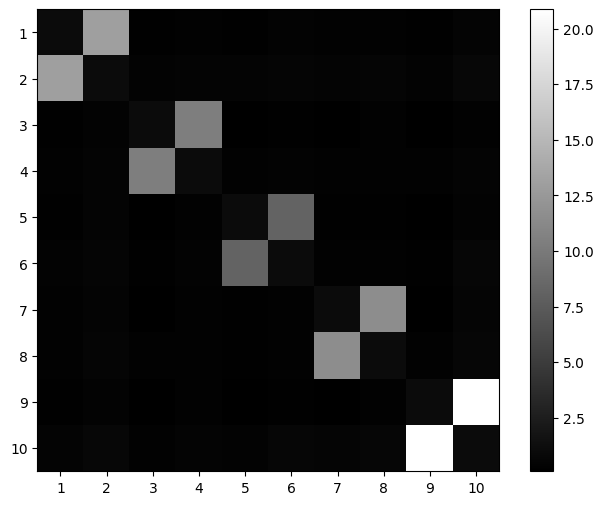

In [19]:
matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2
print(symmetric_matrix)
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

Normalized matrix with diagonals set to 1:
[[1.         0.62554051 0.00903702 0.01593872 0.01218157 0.01854955
  0.0127373  0.01477255 0.01220395 0.02239328]
 [0.62554051 1.         0.01650519 0.02371159 0.02353469 0.02472022
  0.02253689 0.02470837 0.01654582 0.03378071]
 [0.00903702 0.01650519 1.         0.49498373 0.00466831 0.01012926
  0.00780717 0.01357931 0.00571999 0.01454367]
 [0.01593872 0.02371159 0.49498373 1.         0.01476915 0.01679617
  0.01588577 0.0155073  0.01459934 0.02180993]
 [0.01218157 0.02353469 0.00466831 0.01476915 1.         0.39068745
  0.00877649 0.01186316 0.006097   0.01912634]
 [0.01854955 0.02472022 0.01012926 0.01679617 0.39068745 1.
  0.01533987 0.01545639 0.01058207 0.02883152]
 [0.0127373  0.02253689 0.00780717 0.01588577 0.00877649 0.01533987
  1.         0.55341504 0.00836468 0.02417462]
 [0.01477255 0.02470837 0.01357931 0.0155073  0.01186316 0.01545639
  0.55341504 1.         0.01433468 0.02972212]
 [0.01220395 0.01654582 0.00571999 0.01459934

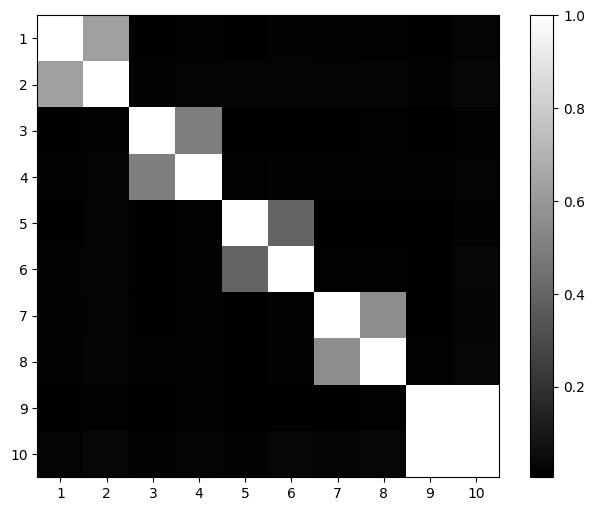

In [20]:
# Normalise with maximum value of the matrix.
max_value = np.max(symmetric_matrix)

normalized_matrix = symmetric_matrix / max_value

np.fill_diagonal(normalized_matrix, 1)

print("Normalized matrix with diagonals set to 1:")
print(normalized_matrix)


plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

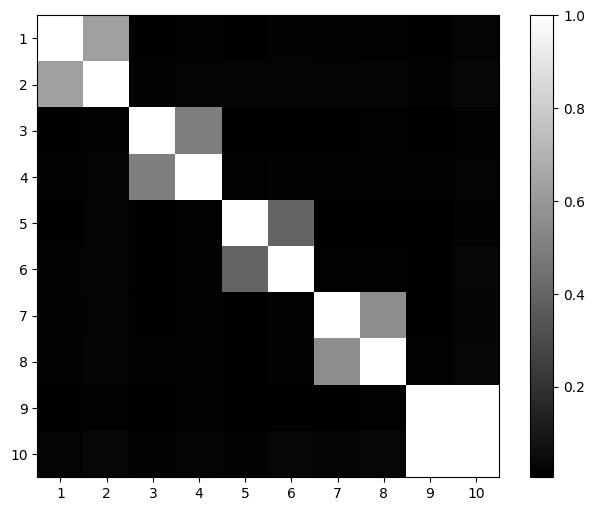

In [21]:


matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2

# Find the largest non-diagonal value
max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))

# Divide the matrix by the largest non-diagonal value
if max_value != 0:
    symmetric_matrix /= max_value


np.fill_diagonal(symmetric_matrix, 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [22]:
symmetric_matrix

array([[1.        , 0.62554051, 0.00903702, 0.01593872, 0.01218157,
        0.01854955, 0.0127373 , 0.01477255, 0.01220395, 0.02239328],
       [0.62554051, 1.        , 0.01650519, 0.02371159, 0.02353469,
        0.02472022, 0.02253689, 0.02470837, 0.01654582, 0.03378071],
       [0.00903702, 0.01650519, 1.        , 0.49498373, 0.00466831,
        0.01012926, 0.00780717, 0.01357931, 0.00571999, 0.01454367],
       [0.01593872, 0.02371159, 0.49498373, 1.        , 0.01476915,
        0.01679617, 0.01588577, 0.0155073 , 0.01459934, 0.02180993],
       [0.01218157, 0.02353469, 0.00466831, 0.01476915, 1.        ,
        0.39068745, 0.00877649, 0.01186316, 0.006097  , 0.01912634],
       [0.01854955, 0.02472022, 0.01012926, 0.01679617, 0.39068745,
        1.        , 0.01533987, 0.01545639, 0.01058207, 0.02883152],
       [0.0127373 , 0.02253689, 0.00780717, 0.01588577, 0.00877649,
        0.01533987, 1.        , 0.55341504, 0.00836468, 0.02417462],
       [0.01477255, 0.02470837, 0.0135793

[[1.    0.626 0.009 0.016 0.012 0.019 0.013 0.015 0.012 0.022]
 [0.626 1.    0.017 0.024 0.024 0.025 0.023 0.025 0.017 0.034]
 [0.009 0.017 1.    0.495 0.005 0.01  0.008 0.014 0.006 0.015]
 [0.016 0.024 0.495 1.    0.015 0.017 0.016 0.016 0.015 0.022]
 [0.012 0.024 0.005 0.015 1.    0.391 0.009 0.012 0.006 0.019]
 [0.019 0.025 0.01  0.017 0.391 1.    0.015 0.015 0.011 0.029]
 [0.013 0.023 0.008 0.016 0.009 0.015 1.    0.553 0.008 0.024]
 [0.015 0.025 0.014 0.016 0.012 0.015 0.553 1.    0.014 0.03 ]
 [0.012 0.017 0.006 0.015 0.006 0.011 0.008 0.014 1.    1.   ]
 [0.022 0.034 0.015 0.022 0.019 0.029 0.024 0.03  1.    1.   ]]


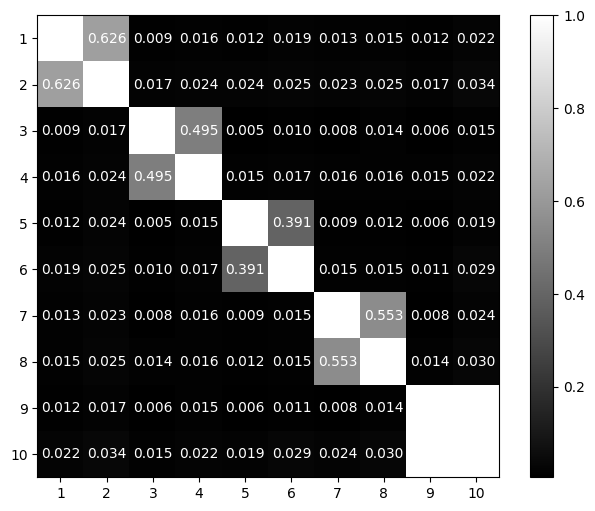

In [23]:

symmetric_matrix_rounded = np.round(symmetric_matrix, decimals=3)

print(symmetric_matrix_rounded)

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix_rounded, cmap='gray', interpolation='nearest')
plt.colorbar()

for i in range(len(symmetric_matrix)):
    for j in range(len(symmetric_matrix[0])):
        plt.text(j, i, f'{symmetric_matrix_rounded[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()
